# Chapter 65: Feedforward Neural Networks

### Runs simulations for Examples 8 and 9 in Chapter 65: Support Vector Machines (vol. III)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

from functions import *

## Sigmoid and tanh functions

There are several common choices for the activation function $f(z)$, listed in Table 65.2, with some of them illustrated in Fig. 65.2. We encountered the sigmoid function earlier in (59.5a) while discussing the logistic regression problem. One useful property of the sigmoid function is that its derivative admits the representation

$$
f'(z)=f(z)(1-f(z))\;\;\;\;\;(\textbf{sigmoid function}) \tag{65.6}
$$

We also encountered the hyperbolic tangent function  earlier in (27.33) while studying the optimal mean-square-error (MSE)  inference problem. Its derivative is given by any of the forms:

$$
\begin{align*} &
f'(z)=1/\cosh^2(z)\\ &
=4/(e^z+e^{-z})^2\\ &
=1-(\textnormal{tanh}(z))^2\;\;\;\;\;(\textbf{tanh function})
\end{align*} \tag{65.7}
$$

The sigmoid and tanh functions are related via the translation

$$
\frac{1}{1+e^{-z}}=\frac{1}{2}\left(\tanh\left(z/2\right)+1\right)
\Longleftrightarrow\;\textnormal{tanh}(z/2)=2\,\textnormal{sigmoid}(z)-1 \tag{65.8}
$$

and satisfy

$$
\begin{align*} &
(\textbf{sigmoid function})\; \lim_{z\rightarrow+\infty} f(z)=1,\;\;\;\; \lim_{z\rightarrow-\infty} f(z)=0 \tag{65.9a} \\ &
(\textbf{tanh function})\; \lim_{z\rightarrow+\infty} f(z)=1,\;\;\;\; \lim_{z\rightarrow-\infty} f(z)=-1 \tag{65.9b}
\end{align*}
$$

That is, both functions saturate for large $|z|$. This means that when $|z|$ is large, the derivatives of the sigmoid and tanh functions will assume small values close to $0$. We will explain in  Section 65.8 that this property is problematic and is responsible for a $\textit{slowdown}$ in the speed of learning by neural networks. This is because  small derivative values at any neuron will end up limiting the learning ability of the neurons in the preceding layers.

The scaled hyperbolic tangent function, $f(z)=a\tanh(bz)$, maps the real axis to the interval $[-a,a]$ and, therefore, it saturates at $\pm a$ for large values of $z$. Typical choices for the parameters $(a,b)$ are

$$
b=\frac{2}{3},\;\;\;\;a=\frac{1}{\tanh(2/3)}\approx 1.7159 \tag{65.10}
$$

With these values, one finds that $f(\pm 1)=\pm 1$. In other words, when the input value $z$ approaches $\pm 1$ (which are common values in binary classification problems), then the scaled hyperbolic tangent will assume the same values $\pm 1$, which are sufficiently away from the saturation levels of $\pm 1.7159$.

**Table 65.1** Typical choices for the activations function $f(z)$ used in (65.5)
$$
\begin{array}{c|c}
\textnormal{Activation Function} & f(z) \\ \hline \\
\textnormal{sigmoid or logistic} & f(z)=\dfrac{1}{1+e^{-z}} \\ \\
\textnormal{softplus} & f(z)=\ln(1+e^z) \\ \\
\textnormal{hyperbolic tangent (tanh)} & f(z)=\tanh(z)\overset{\Delta}{=}\dfrac{e^z-e^{-z}}{e^z+e^{-z}} \\ \\
\textnormal{scaled tanh} & f(z)=a\tanh(bz), a,b>0 \\ \\
\textnormal{ReLU (hinge)} & (z)=\max\,\{0,z\} \\ \\ 
\textnormal{leaky  ReLU} & f(z) = \left\{ \begin{array}{ll} z, & z\geq 0 \\ 0.01z, & z < 0\end{array} \right.\ \\ \\ 
\textnormal{ELU} & f(z) = \left\{ \begin{array}{ll} z, & z\geq 0 \\ \alpha (e^z-1), & z < 0\end{array} \right.\ \\ \\
\textnormal{no activation} & f(z) = z
\end{array}
$$

## ReLU and leaky ReLU functions

In the rectifier (or hinge) function listed in Table 65.1 (also called a "rectified linear unit" or  ReLU function), nonnegative values of $z$ remain unaltered while negative values of $z$ are set to zero. In this case, we set the derivative value at $z=0$ to $f'(0)=0$ by convention (we could also set it to 1, if desired):

$$
f(z)=  \textnormal{ReLU} (z)\;\Longrightarrow\;f'(z)=
\left\{
\begin{array}{ll}0,&z<0\\0,&z=0\\1,&z>0\end{array}
\right. \tag{65.11}
$$

Compared with the sigmoid function, we observe that the derivative of  ReLU is constant and equal to 1 for all positive values of $z$; this property will help speed up the training of neural networks and is one of the main reasons why  ReLU activation functions are generally preferred over sigmoid functions.  ReLU functions are also easy to implement and do not require the exponentiation operation that appears in the sigmoid implementation. 

Unfortunately, the derivative of the  ReLU function is zero for negative values of $z$, which will affect training when internal values in the network drop below zero. These nodes will not be able to continue learning and recover from their state of negative $z$ -values. This challenge is referred to as the "dying  ReLU" problem. The softplus function provides a smooth approximation for the rectifier function, tending to zero gracefully as $z\rightarrow-\infty$.  The leaky ReLU version, on the other hand, incorporates a small positive gradient for $z<0$:

$$
f(z)=\textnormal{leaky  ReLU(z)}\;\Longrightarrow\;f'(z)=
\left\{
\begin{array}{ll}0.01,&z<0\\0,&z=0\\1,&z>0\end{array}
\right. \tag{65.11}
$$

The exponential linear unit (ELU) also addresses the problem over negative $z$ by incorporating an exponential decay term such that as $z\rightarrow-\infty$, the function ELU $(z)$ will tend to - $\alpha$ where $\alpha>0$. The value of $\alpha$ can be selected through a (cross validation) training process by simulating the performance of the neural network with different choices for $\alpha$. The rectifier functions are widely used within hidden layers in the training of deep and convolutional neural networks. ELU activation functions have been observed to lead to neural networks with higher classification performance than   ReLUs. 

In [2]:
z = np.arange(-5, 5, 0.01)

sigmoid = 1/(1+np.exp(-z))
hytanh = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
rect = z*(z > 0)
rectpsoft = np.log(1+np.exp(z))

sigmoiddiff = sigmoid*(1-sigmoid)
hytanhdiff = 4/((np.exp(z)+np.exp(-z))**2)
rectdiff = 1*(z>0)
rectpsoftdiff = 1/(1+np.exp(-z))

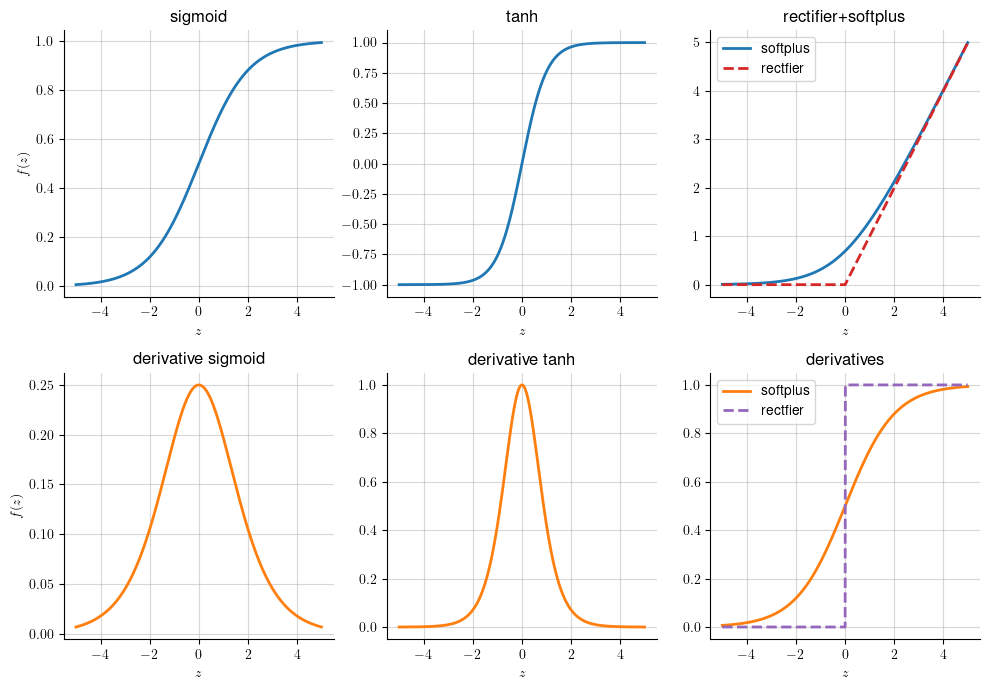

In [3]:
# figure 2 (activation functions and their derivatives)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 7
fig = plt.figure()

ax = fig.add_subplot(231)
ax.plot(z, sigmoid, linewidth=2)
ax.set_xlabel("$z$", fontsize=10)
ax.set_ylabel("$f(z)$", fontsize=10)
ax.set_title("sigmoid", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(232)
ax.plot(z, hytanh, linewidth=2)
ax.set_xlabel("$z$", fontsize=10)
ax.set_title("tanh", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(233)
ax.plot(z, rectpsoft, label="softplus", linewidth=2)
ax.plot(z, rect, label="rectfier", color="tab:red", linestyle="dashed", linewidth=2)
ax.set_xlabel("$z$", fontsize=10)
ax.set_title("rectifier+softplus", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(234)
ax.plot(z, sigmoiddiff, linewidth=2, color="tab:orange")
ax.set_xlabel("$z$", fontsize=10)
ax.set_ylabel("$f(z)$", fontsize=10)
ax.set_title("derivative sigmoid", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(235)
ax.plot(z, hytanhdiff, linewidth=2, color="tab:orange")
ax.set_xlabel("$z$", fontsize=10)
ax.set_title("derivative tanh", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(236)
ax.plot(z, rectpsoftdiff, label="softplus", linewidth=2, color="tab:orange")
ax.plot(z, rectdiff, label="rectfier", color="tab:purple", linestyle="dashed", linewidth=2)
ax.set_xlabel("$z$", fontsize=10)
ax.set_title("derivatives", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.tight_layout()

plt.savefig("figs/fig-2.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 65.2** Examples of activation functions and their derivatives. ($\textit{Left}$) Sigmoid function. ($\textit{Center}$) Hyperbolic tangent function. ($\textit{Right}$) Rectifier and softplus functions.

## Example 65.9 (Classification of handwritten digits)

We illustrate the operation of a neural network by applying it to the problem of identifying handwritten digits using 
the same MNIST dataset considered earlier in Example 52.3. The dataset consists of 60,000 labeled training samples and 10,000 labeled testing samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784-$long feature vector, $h_n$. Each pixel in the image and, therefore, each entry in $h_n$, assumes integer values in the range $[0,255]$. Every feature vector (or image) is assigned an integer label in the range 0--9, depending on which digit the image corresponds to. The earlier Fig. 52.6, which is repeated here as Fig. 65.12, shows randomly selected images from the training dataset.

We pre-process the images (or the corresponding feature vectors $\{h_n\}$) by scaling their entries by $255$ (so that they assume values in the range $[0,1]$). We subsequently compute the mean feature vectors for both the training and test sets. We center the scaled feature vectors around these means in both sets. The earlier Fig. 52.7 showed randomly selected images for the digits $\{0,1\}$ before and after processing.  
 
 
We construct a neural network with a total of four layers: one input layer, one output layer, and two hidden layers. The size of the input layer is $n_1=784$ (which agrees with the size of the feature vectors), while the size of the output layer is $n_4=10$ (which agrees with the number of classes). The size of the hidden layers is set to $n_2=n_3=512$ neurons. We  employ a softmax layer at the output  and train  the network using a regularized cross-entropy criterion with parameters

$$
\mu=0.001,\;\;\;\rho=0.0001 \tag{65.151}
$$

We run $P=200$ passes of the stochastic-gradient algorithm (65.150) over the training data, with the data being randomly reshuffled at the start of each pass. At the end of the training phase, we evaluate the empirical error rate over the 10,000 test samples, as well as over the 60,000 training samples. We simulate three different scenarios where we vary the nonlinearity at the output of the internal neurons: sigmoid, rectifier, and tanh. We also simulate a dropout implementation with $p_{1}=0.1$ for the input layer and $p_2=p_3=0.5$ for the two hidden layers; in this last simulation, we use the sigmoid activation function for the internal nodes and perform the same number of  passes, 200,  over the data. The results are summarized in 
Table 65.3. The performance under dropout can be improved by using a larger number of passes due to the slower convergence in this case. 

**Table 65.3** The table lists the empirical error rates over both the test and training samples from the MNIST dataset for three types of internal nonlinearities: sigmoid, rectifier, and tanh. The last row in the table corresponds to a dropout implementation using 200 passes over the data, the sigmoid activation function, and putting $50\%$ of the neurons in the hidden layers to sleep at each iteration.The table lists the empirical error rates over both the test and training samples from the MNIST dataset for three types of internal nonlinearities: sigmoid, rectifier, and tanh. The last row in the table corresponds to a dropout implementation using 200 passes over the data, the sigmoid activation function, and putting $50\%$ of the neurons in the hidden layers to sleep at each iteration.
$$
\begin{array}{|c|c|c|c|c|}
\hline
\textnormal{Nonlinearity} & \textnormal{Empirical test error} & \textnormal{Number of test errors} & \textnormal{Empirical training error} & \textnormal{Number of training errors} \\ \hline 
\textnormal{sigmoid} & 2.18\% & 218 & 1.02\% & 613 \\ 
\textnormal{tanh} & 1.84\% & 184 & 0.00167\% & 1 \\
\textnormal{rectifier} & 1.82\% & 182 & 0.00167\% & 1 \\ \hline 
\textnormal{dropout} & 6.22\% & 622 & 6.25\% & 3752 \\ \hline
\end{array}
$$


In [2]:
# The user can set five flags:

# 1) input data: MNIST or CIFAR10
choose_data = 1  # 1 = MNIST,  2 = CIFAR

# 2) Use dropout or not
dropout = 1  # 1: use dropout; 0: do not use dropout

# 3) type of risk function
type_ = 3  # 1: sigmoid, 2: tanh, 3: rectifier

# 4) type of risk function
cost = 1  # 0: least-squares, 1: cross-entropy

# 5) Choose if the output layer should be softmax
softmax = 1  # set to 1 to use softmax; otherwise set to zero

if choose_data == 1:
    # MNIST dataset
    mnist_data = scipy.io.loadmat("data/mnist_normalized.mat") # loaded mnist data; features are centered and variance-normalized
    features_train = mnist_data["train_features_norm"] # 60,000 x 784
    labels_train = mnist_data["train_norm_labels"] # 10 digit labels 
    features_test = mnist_data["test_features_norm"] # 10,000 x 784
    labels_test = mnist_data["test_norm_labels"] # 10 digit labels

    n2 = 512 # number of nodes in hidden layer 2
    n3 = 512 # number of nodes in hidden layer 3

else:
    # CIFAR-10 dataset
    data_batch_1 = scipy.io.loadmat("data/data_batch_1_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = data_batch_1["train_features_norm_1"] # 10,000 x 3072
    labels_train = data_batch_1["train_labels_norm_1"] # labels 0, 1, ..., 9

    data_batch_2 = scipy.io.loadmat("data/data_batch_2_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_2["train_features_norm_2"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_2["train_labels_norm_2"]]) # labels 0, 1, ..., 9

    data_batch_3 = scipy.io.loadmat("data/data_batch_3_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_3["train_features_norm_3"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_3["train_labels_norm_3"]]) # labels 0, 1, ..., 9

    data_batch_4 = scipy.io.loadmat("data/data_batch_4_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_4["train_features_norm_4"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_4["train_labels_norm_4"]]) # labels 0, 1, ..., 9

    data_batch_5 = scipy.io.loadmat("data/data_batch_5_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_5["train_features_norm_5"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_5["train_labels_norm_5"]]) # labels 0, 1, ..., 9

    test_data_batch = scipy.io.loadmat("data/test_batch_normalized.mat") # loaded CIFAR-10 data; features are centered and variance-normalized.
    features_test = test_data_batch["test_features_norm"]
    labels_test = test_data_batch["test_labels_norm"]

    n2 = 2048 # number of nodes in hidden layer 2
    n3 = 2048 # number of nodes in hidden layer 3

number_of_classes = 10
mu = 0.001 # step-size
rho = 0.0001 # l2-regularization
number_of_passes = 200 # epochs

# dropout parameters
p_vec = [0.1, 0.5, 0.5] # Bernoulli probabilities for input layer and the two hidden layers value of p = probability of node turned off

# Choose type of activation function
if type_ == 1: #1: sigmoid, 2: tanh, 3: rectifier
    activation = "sigmoid"
elif type_ == 2:
    activation = "tanh" 
elif type_ == 3:
    activation = "rectifier"

if cost == 1: # to make sure that when cross-entropy is used, softmax is also used
    softmax = 1

if activation == "rectifier": # to make sure that when rectifier is used, softmax is also used
    softmax = 1

L = 4 # total number of layers, including input and output layers --> L-2 hidden layers

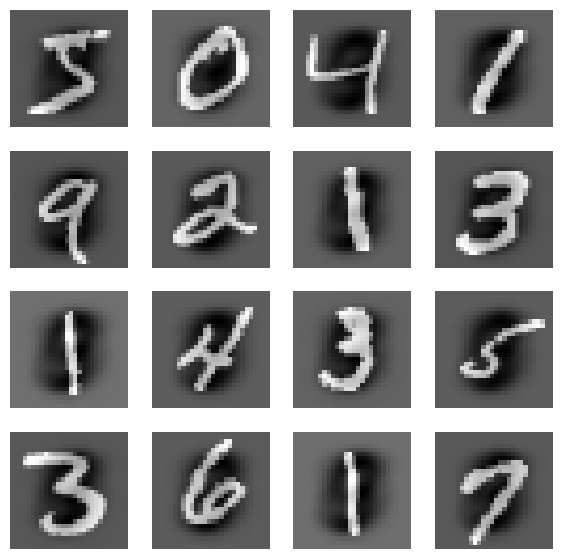

In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(16):

    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(features_train[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

**Figure 65.12** Randomly selcted images from the MNIST dataset for handwritten digits. Each image is 28x28 grayscale with the pixels assuming integer values in the reange [0, 255].

In [60]:
number_of_passes = 10
Wcell, ThetaCell = train_feedforward_neural_network(
    L, number_of_classes, mu, rho, number_of_passes, features_train, labels_train,
    n2, n3, dropout, activation, softmax, p_vec, cost)

100%|██████████| 60000/60000 [06:03<00:00, 165.17it/s]


In [63]:
N_test = features_test.shape[0]
test_error = get_inference_error(L, features_test, labels_test, number_of_classes, Wcell, ThetaCell, softmax, activation)
print("Dropout: ", dropout)
print("Numver of test points, number of errors, empirical error on test data:")
print(N_test, test_error, (test_error/N_test)*100)

100%|██████████| 10000/10000 [00:06<00:00, 1633.22it/s]

Dropout:  1
Numver of test points, number of errors, empirical error on test data:
10000 508 5.08


In [64]:
N_train = features_train.shape[0]
train_error = get_inference_error(L, features_train, labels_train, number_of_classes, Wcell, ThetaCell, softmax, activation)
print("Number of passes: ", number_of_passes)
print("Number of test points, number of errors, empirical error on train data:")
print(N_train, train_error, (train_error/N_train)*100)

100%|██████████| 60000/60000 [00:33<00:00, 1770.09it/s]

Number of passes:  10
Number of test points, number of errors, empirical error on train data:
60000 3141 5.235


## Example 65.10 (Classification of tiny color images)

We again illustrate the operation of neural networks by applying them to the problem of classifying color images into 1 of 10 classes using the CIFAR-10 dataset. This dataset consists of color images that can belong to 1 of $10$ classes: airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Figure 65.13 shows random selections of images  from the dataset. The images in the dataset have low resolution and that is why they appear blurred.

There are 6,000 images per class for a total of 60,000 images in the dataset.
There are 50,000 training images and 10,000 test images. There are 1,000 random images from each class in the test collection of 10,000 images. The training images are divided into 5 batches of 10,000 images each. Each training batch may contain more images from one class or another. 

Each image has size 32 $\times$ 32 in the red, green, and blue color channels, which we transform into an $M=32\times 32\times 3 = 3072-$long feature vector, $h_n$. Each pixel in the image assumes integer values in the range $[0,255]$.  Each feature vector (or image) is assigned an integer class label in the range 0--9. We pre-process the images (or the corresponding feature vectors $\{h_n\}$) by scaling their entries by $255$ (so that they assume values in the range $[0,1]$). We subsequently compute the mean feature vectors for the training and test sets and center the scaled feature vectors in both sets around these means.

We construct a neural network with a total of four layers: one input layer, one output layer, and two hidden layers. The size of the input layer is $n_1=3072$ (which agrees with the size of the feature vectors), while the size of the output layer is $n_4=10$ (which agrees with the number of classes). The size of the hidden layers is set to $n_2=n_3=2048$ neurons. We employ a softmax layer at the output of the network, and rectifier units at the internal neurons. We train  the network using a regularized cross-entropy criterion with parameters

$$
\mu=0.001,\;\;\;\rho=0.0001 \tag{65.152}
$$

We run a stochastic-gradient version of the backpropagation algorithm (65.82) with mini-batches of size equal to one sample, and adjusted to the cross-entropy scenario where the boundary condition $\delta_{L,b}$ is replaced by

$$
\delta_{L,b}=\widehat{\gamma}_b-\gamma_b \tag{65.153}
$$

We run $P=200$ passes of the stochastic-gradient algorithm (65.150) over the training data, with the data being randomly reshuffled at the start of each pass.  At the end of the training phase, we evaluate the empirical error rate over the 10,000 test samples and also over the 50,000 training samples. We also simulate a dropout implementation with $p_{1}=0.1$ for the input layer and $p_2=p_3=0.5$ for the two hidden layers using now $P=300$ passes over the data. The results are summarized in 
Table 65.4. It is seen from the results on the test data that this is a more challenging classification problem. We will revisit this problem in a future chapter when we study convolutional neural networks.

**Table 65.4** The table lists the empirical error rates over 10,000 test samples and 50,000 training samples from the CIFAR-10 dataset with and without dropout.

$$
\begin{array}{|c|c|c|c|c|}
\hline
\textnormal{Nonlinearity} & \textnormal{Empirical test error} & \textnormal{Number of test errors} & \textnormal{Empirical training error} & \textnormal{Number of training errors} \\ \hline 
\textnormal{w/o dropout} & 42.28\% & 4228 & 0.02\% & 10 \\ 
\textnormal{w/ dropoout} & 42.92\% & 4292 & 5.62\% & 2810 \\ \hline
\end{array}
$$

In [14]:
# The user can set five flags:

# 1) input data: MNIST or CIFAR10
choose_data = 0  # 1 = MNIST,  2 = CIFAR

# 2) Use dropout or not
dropout = 1  # 1: use dropout; 0: do not use dropout

# 3) type of risk function
type_ = 3  # 1: sigmoid, 2: tanh, 3: rectifier

# 4) type of risk function
cost = 1  # 0: least-squares, 1: cross-entropy

# 5) Choose if the output layer should be softmax
softmax = 1  # set to 1 to use softmax; otherwise set to zero

if choose_data == 1:
    # MNIST dataset
    mnist_data = scipy.io.loadmat("data/mnist_normalized.mat") # loaded mnist data; features are centered and variance-normalized
    features_train = mnist_data["train_features_norm"] # 60,000 x 784
    labels_train = mnist_data["train_norm_labels"] # 10 digit labels 
    features_test = mnist_data["test_features_norm"] # 10,000 x 784
    labels_test = mnist_data["test_norm_labels"] # 10 digit labels

    n2 = 512 # number of nodes in hidden layer 2
    n3 = 512 # number of nodes in hidden layer 3

else:
    # CIFAR-10 dataset
    data_batch_1 = scipy.io.loadmat("data/data_batch_1_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = data_batch_1["train_features_norm_1"] # 10,000 x 3072
    labels_train = data_batch_1["train_labels_norm_1"] # labels 0, 1, ..., 9

    data_batch_2 = scipy.io.loadmat("data/data_batch_2_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_2["train_features_norm_2"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_2["train_labels_norm_2"]]) # labels 0, 1, ..., 9

    data_batch_3 = scipy.io.loadmat("data/data_batch_3_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_3["train_features_norm_3"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_3["train_labels_norm_3"]]) # labels 0, 1, ..., 9

    data_batch_4 = scipy.io.loadmat("data/data_batch_4_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_4["train_features_norm_4"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_4["train_labels_norm_4"]]) # labels 0, 1, ..., 9

    data_batch_5 = scipy.io.loadmat("data/data_batch_5_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_5["train_features_norm_5"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_5["train_labels_norm_5"]]) # labels 0, 1, ..., 9

    test_data_batch = scipy.io.loadmat("data/test_batch_normalized.mat") # loaded CIFAR-10 data; features are centered and variance-normalized.
    features_test = test_data_batch["test_features_norm"]
    labels_test = test_data_batch["test_labels_norm"]

    n2 = 2048 # number of nodes in hidden layer 2
    n3 = 2048 # number of nodes in hidden layer 3

number_of_classes = 10
mu = 0.001 # step-size
rho = 0.0001 # l2-regularization
number_of_passes = 200 # epochs

# dropout parameters
p_vec = [0.1, 0.5, 0.5] # Bernoulli probabilities for input layer and the two hidden layers value of p = probability of node turned off

# Choose type of activation function
if type_ == 1: #1: sigmoid, 2: tanh, 3: rectifier
    activation = "sigmoid"
elif type_ == 2:
    activation = "tanh" 
elif type_ == 3:
    activation = "rectifier"

if cost == 1: # to make sure that when cross-entropy is used, softmax is also used
    softmax = 1

if activation == "rectifier": # to make sure that when rectifier is used, softmax is also used
    softmax = 1

L = 4 # total number of layers, including input and output layers --> L-2 hidden layers

In [33]:
features_train[123]

array([0.1568302 , 0.15556235, 0.1561051 , ..., 0.40346784, 0.40265843,
       0.39958549])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


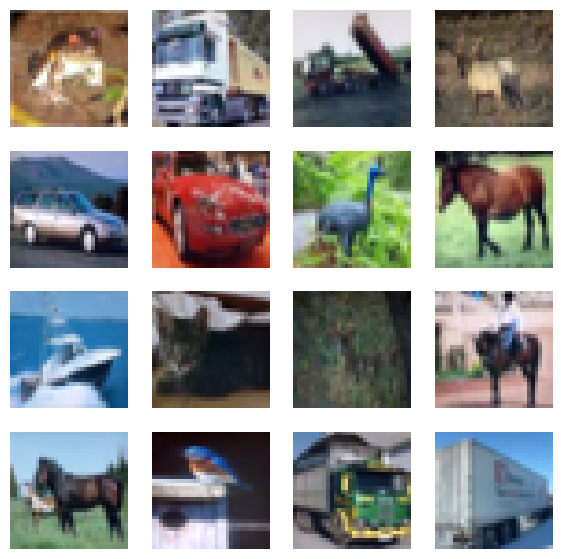

In [47]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(16):

    ax = fig.add_subplot(4, 4, i+1)
    image = np.swapaxes(features_train[i].reshape(32, 32, 3, order="F"), 0, 1)
    image = (image*255).astype(np.int16)
    min_ = image.min()
    image += -min_+1
    ax.imshow(image)
    plt.axis("off")

**Figure 65.13** Randomly selected color images from the CIFAR-10 dataset. Each image has three channels (red, green, blue) of size $32\times 32$ each. The pixels in each channel assume integer values in the range $[0,255]$. The CIFAR-10 dataset is found at www.cs.toronto.edu/~kriz/cifar.html.

In [66]:
number_of_passes = 10
Wcell, ThetaCell = train_feedforward_neural_network(
    L, number_of_classes, mu, rho, number_of_passes, features_train, labels_train,
    n2, n3, dropout, activation, softmax, p_vec, cost)

100%|██████████| 50000/50000 [1:18:03<00:00, 10.68it/s]


In [67]:
N_test = features_test.shape[0]
test_error = get_inference_error(L, features_test, labels_test, number_of_classes, Wcell, ThetaCell, softmax, activation)
print("Dropout: ", dropout)
print("Numver of test points, number of errors, empirical error on test data:")
print(N_test, test_error, (test_error/N_test)*100)

100%|██████████| 10000/10000 [00:49<00:00, 202.52it/s]

Dropout:  1
Numver of test points, number of errors, empirical error on test data:
10000 5626 56.26


In [68]:
N_train = features_train.shape[0]
train_error = get_inference_error(L, features_train, labels_train, number_of_classes, Wcell, ThetaCell, softmax, activation)
print("Number of passes: ", number_of_passes)
print("Number of test points, number of errors, empirical error on train data:")
print(N_train, train_error, (train_error/N_train)*100)

100%|██████████| 50000/50000 [04:15<00:00, 195.40it/s]

Number of passes:  10
Number of test points, number of errors, empirical error on train data:
50000 28138 56.276
